# Objective:
The goal of this notebook is to create a standardized method for processing our data. The original datasets downloaded from the King County website are extremely large (see Data Download section of the readme), but by the end of this notebook they will be much smaller, allowing all further analysis to be performed easily with Pandas. 

## Process Overview:
### 1. Import
All data in the project will be stored in a 'data' folder found in the projects main directory.

### 2. Filtering
Once imported, the data will then be filtered to include only sales and properties that would be of interest to our target audience, which is primarily prospective homeowners.

### 3. Export
Once properly filter, the new dataframes will be exported with the suffix '_filtered'. For instance EXTR_RPSale.csv will become EXTR_RPSale_filtered.csv.

# 1. Import

### A. Set-up
Before we begin the data import, we'll set up our notebook with a few important modules and variables. First we'll add our repository home directory to our path so that we can import our custom modules:

In [1]:
#let's add the project directory to our module path
import os
import sys

module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

Then we'll import the remainder of the modules we'll be using, as well as setting our data_folder variable to the path of our data folder.

In [2]:
#also import the rest of our modules
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats
from src import data_cleaning

data_folder = '../../data/'

### B. Data Import

We'll be looking at only two of our CSVs for the initial data cleaning process. These CSV's are quite large and will take some time to load. 

#### Note on Unique Identifiers
Note the parameters passed to the read_csv method below. The data types of a few of the columns MUST be declared through the dtypes method. This is because the unique identifier for a piece of land will be created using the Major and Minor columns. For example, the first entry in our sales data will have a Major value of 919715 and a Minor value of 0200, so our unique identifer would be 9197150200. These values are numeric, but are also zero padded, therefore importing as an integer would remove the zero padding and result in an incorrect unique identifer of 919715200. We'll go into more detail on the unique identifiers (PINS) later on.

In [3]:
rp_sale = pd.read_csv(data_folder+'EXTR_RPSale.csv', dtype={'Major': 'string', 'Minor':'string'})
res_bldg = pd.read_csv(data_folder+'EXTR_ResBldg.csv', dtype={'Major': 'string', 'Minor':'string', 'ZipCode': 'string'})

# 2. Filtering

The motivation behind filtering the data set comes from our target audience, home buyers. Our original data set contains sales deeds that may not provide accurate information for home buyers, such as foreclosure deeds as well as sales pertaining to commercial or public property.

Specifically, we are looking at the following properties:
- A. Property that was sold in 2019, to see the factors that affect the current market.

- B. Property that was sold, as opposed to foreclosed or transferred as part of a settlement.

- C. Property that is residential, as opposed to commercial.

- D. Property that was not 'sold' for a value of zero dollars, as these represent sales circumstances such as inheritance, which does not provide accurate portrayal of a property's value.

- E. Property that has one building on a given tax parcel. Our data does not include an accurate way to differentiate the values for multiple homes on a single parcel, so these will be excluded to maintain accuracy.

- F. Property that is not a mansion, simply because first time homebuyers are likely not investing in  mansions.

Each of the previous criteria represent one filter that will be applied to the data sets.

### A. Was sold in 2019

This filter cuts the most substantial amount of entries from our data set, which records sales from at least a few decades ago. It's using a filter function that first converts all document dates to a pandas DateTime object, then filters all events that are not from 2019.

In [4]:
filter_a = data_cleaning.filter_data_by_year(rp_sale, 2019)
filter_a

,ExciseTaxNbr,Major,Minor,DocumentDate,SalePrice,RecordingNbr,Volume,Page,PlatNbr,PlatType,...,PropertyType,PrincipalUse,SaleInstrument,AFForestLand,AFCurrentUseLand,AFNonProfitUse,AFHistoricProperty,SaleReason,PropertyClass,SaleWarning
72,2999169,919715,0200,2019-07-08,192000,20190712001080,,,,,...,3,2,3,N,N,N,N,1,3,
236,3000673,894444,0200,2019-06-26,185000,20190722001395,,,,,...,3,2,3,N,N,N,N,1,3,
257,3027422,213043,0120,2019-12-20,560000,20191226000848,,,,,...,11,6,3,N,N,N,N,1,8,
302,3002257,940652,0630,2019-07-22,435000,20190730001339,,,,,...,11,6,3,N,N,N,N,1,8,
446,3018109,152504,9008,2019-10-18,7600000,20191030001615,,,,,...,3,7,3,N,N,N,N,1,2,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2087782,2986698,033310,0255,2019-04-30,6500000,20190508000847,,,,,...,11,6,3,N,N,N,N,1,8,
2087856,2980997,334840,1022,2019-04-03,29000,20190405000544,,,,,...,1,6,18,N,N,N,N,18,7,13 31
2087900,2997920,302300,0320,2019-05-01,0,20190705000539,,,,,...,11,6,15,N,N,N,N,1,8,
2087907,3028691,277110,4239,2019-12-19,955000,20200103000685,,,,,...,10,6,3,N,N,N,N,1,8,


It cuts about 2 million entries.

In [5]:
print(f'Change in dataset size: {len(filter_a) - len(rp_sale)}')

Change in dataset size: -2026593


Ultimately we'll need normally distributed data in order for our regression model to fit, so let's keep track of what these filters do to our data. Here's a look at what the data looks like right now.

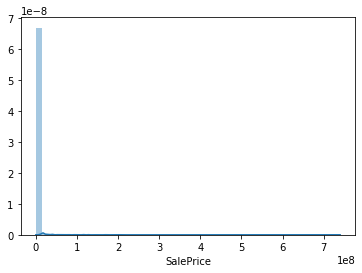

In [6]:
sns.distplot(filter_a.SalePrice)

We'll keep track of that as we go throughout our filtering process.

### B. Is listed as some sale other than foreclosures, settlements, etc. 
i.e. a standard sale.

A note on Look Up codes. For many of our filters, we will be utilizing the data set's 'LookUp' codes found in the EXTR_LookUp.csv. To use look up codes to find sale reason, we will check the column description in this data sets .doc file (this is found in the projects 'references/data_documentation' folder. Reading the description for the Sale Reason column tells us that it is assigned the lookup code 5. Now we can check the EXTR_LookUp.csv to find the meanings for each associated value found in the sale reason column: 

- 1 - None 
- 2 - Assumption         
- 3 - Mortgage Assumption 
- 4 - Foreclosure   
- 5 - Trust     
- 6 - Executor-to admin guardian 
- 7 - Testamentary Trust 
- 8 - Estate Settlement   
- 9 - Settlement      
- 10 - Property Settlement
- 11 - Divorce Settlement      
- 12 - Tenancy Partition    
- 13 - Community Prop Established    
- 14 - Partial Int - love,aff,gft  
- 15 - Easement       
- 16 - Correction (refiling) 
- 17 - Trade         
- 18 - Other      
- 19 - Quit Claim Deed - gift/full or part interest

For the purposes of this filter, we want to exclude everything that does not fall under category 1 (None, no reason listed) or 18 (Other, not specified). All other categories are considered non-standard sales.

In [7]:
filter_b = filter_a[(filter_a['SaleReason']==1)|(filter_a['SaleReason']==18)]
filter_b

,ExciseTaxNbr,Major,Minor,DocumentDate,SalePrice,RecordingNbr,Volume,Page,PlatNbr,PlatType,...,PropertyType,PrincipalUse,SaleInstrument,AFForestLand,AFCurrentUseLand,AFNonProfitUse,AFHistoricProperty,SaleReason,PropertyClass,SaleWarning
72,2999169,919715,0200,2019-07-08,192000,20190712001080,,,,,...,3,2,3,N,N,N,N,1,3,
236,3000673,894444,0200,2019-06-26,185000,20190722001395,,,,,...,3,2,3,N,N,N,N,1,3,
257,3027422,213043,0120,2019-12-20,560000,20191226000848,,,,,...,11,6,3,N,N,N,N,1,8,
302,3002257,940652,0630,2019-07-22,435000,20190730001339,,,,,...,11,6,3,N,N,N,N,1,8,
446,3018109,152504,9008,2019-10-18,7600000,20191030001615,,,,,...,3,7,3,N,N,N,N,1,2,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2087782,2986698,033310,0255,2019-04-30,6500000,20190508000847,,,,,...,11,6,3,N,N,N,N,1,8,
2087856,2980997,334840,1022,2019-04-03,29000,20190405000544,,,,,...,1,6,18,N,N,N,N,18,7,13 31
2087900,2997920,302300,0320,2019-05-01,0,20190705000539,,,,,...,11,6,15,N,N,N,N,1,8,
2087907,3028691,277110,4239,2019-12-19,955000,20200103000685,,,,,...,10,6,3,N,N,N,N,1,8,


This removes very little of are data. This is unsurprising because most non-standard sales are listed with a zero sale price and were thus filtered out with the previous non-zero filter.

In [8]:
print(f'Change in dataset size: {len(filter_b) - len(filter_a)}')

Change in dataset size: -5994


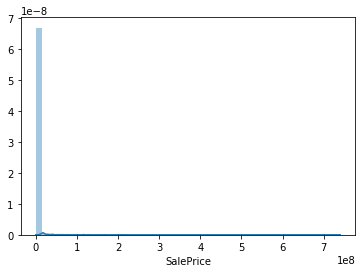

In [9]:
sns.distplot(filter_b.SalePrice)

### C. Is residential
Because we are targetting prospective homeowners, we don't want to look at commercial buildings. The lookup codes assign residential buildings to the PropertyClass values of 7 and 8.

In [10]:
filter_c = filter_b[(filter_b['PropertyClass'] == 7)|(filter_b['PropertyClass'] == 8)]
filter_c

,ExciseTaxNbr,Major,Minor,DocumentDate,SalePrice,RecordingNbr,Volume,Page,PlatNbr,PlatType,...,PropertyType,PrincipalUse,SaleInstrument,AFForestLand,AFCurrentUseLand,AFNonProfitUse,AFHistoricProperty,SaleReason,PropertyClass,SaleWarning
257,3027422,213043,0120,2019-12-20,560000,20191226000848,,,,,...,11,6,3,N,N,N,N,1,8,
302,3002257,940652,0630,2019-07-22,435000,20190730001339,,,,,...,11,6,3,N,N,N,N,1,8,
465,2993601,140281,0020,2019-06-04,450000,20190614000489,,,,,...,3,6,3,N,N,N,N,1,8,
482,3015516,779790,0030,2019-10-07,0,20191016000009,,,,,...,11,6,3,N,N,N,N,1,8,
594,3015264,124550,0098,2019-09-27,193000,20191015000395,,,,,...,3,6,15,N,N,N,N,18,8,18 51 52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2087782,2986698,033310,0255,2019-04-30,6500000,20190508000847,,,,,...,11,6,3,N,N,N,N,1,8,
2087856,2980997,334840,1022,2019-04-03,29000,20190405000544,,,,,...,1,6,18,N,N,N,N,18,7,13 31
2087900,2997920,302300,0320,2019-05-01,0,20190705000539,,,,,...,11,6,15,N,N,N,N,1,8,
2087907,3028691,277110,4239,2019-12-19,955000,20200103000685,,,,,...,10,6,3,N,N,N,N,1,8,


This is a substantial filter, removing approximately 25% of our data.

In [11]:
print(f'Change in dataset size: {len(filter_c) - len(filter_b)}')

Change in dataset size: -13121


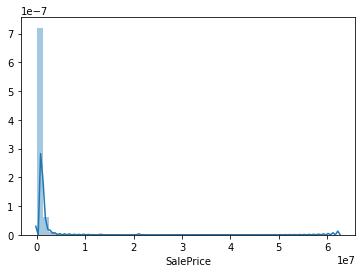

In [12]:
sns.distplot(filter_c.SalePrice)

We can start to see a clearer picture of our distribution now.

### D. Was not sold for zero dollars
Most zero valued sales are the result of some non-standard sale such as inheritance. The reason these sales were not caught by the previous filter b is not known. A further investigation on the nature of these zero_valued homes will be found in a separate notebook in this folder.

In [13]:
filter_d = filter_c[filter_c['SalePrice'] != 0]
filter_d

,ExciseTaxNbr,Major,Minor,DocumentDate,SalePrice,RecordingNbr,Volume,Page,PlatNbr,PlatType,...,PropertyType,PrincipalUse,SaleInstrument,AFForestLand,AFCurrentUseLand,AFNonProfitUse,AFHistoricProperty,SaleReason,PropertyClass,SaleWarning
257,3027422,213043,0120,2019-12-20,560000,20191226000848,,,,,...,11,6,3,N,N,N,N,1,8,
302,3002257,940652,0630,2019-07-22,435000,20190730001339,,,,,...,11,6,3,N,N,N,N,1,8,
465,2993601,140281,0020,2019-06-04,450000,20190614000489,,,,,...,3,6,3,N,N,N,N,1,8,
594,3015264,124550,0098,2019-09-27,193000,20191015000395,,,,,...,3,6,15,N,N,N,N,18,8,18 51 52
599,2980648,797320,2320,2019-03-27,540000,,,,,,...,3,6,3,N,N,N,N,1,8,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2087773,3003079,381670,0025,2019-07-22,680000,20190802000628,,,,,...,11,6,3,N,N,N,N,1,8,
2087774,3025068,615020,0505,2019-11-18,745000,20191212000602,,,,,...,11,6,3,N,N,N,N,1,8,
2087782,2986698,033310,0255,2019-04-30,6500000,20190508000847,,,,,...,11,6,3,N,N,N,N,1,8,
2087856,2980997,334840,1022,2019-04-03,29000,20190405000544,,,,,...,1,6,18,N,N,N,N,18,7,13 31


This is our second most substantial filter, removing about a third of our 2019 sales data.

In [14]:
print(f'Change in dataset size: {len(filter_d) - len(filter_c)}')

Change in dataset size: -11112


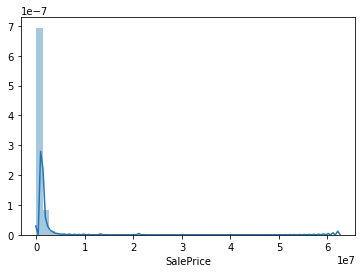

In [15]:
sns.distplot(filter_d.SalePrice)

### E. Property is on a parcel that contains only one building.

Because the sales data does not specify which building on a given parcel is being sold, we limited our data set to only include parcels that have one building one them. This process requires joining our sales data to our residential building data. In order to do this, we need to create a PIN column on which we can join these two data sets.

#### Creating Our Unique Identifier: PINs
The process of creating the PIN column simply involves concatenating the Major and Minor columns. This is the reason these columns must always be imported as strings, otherwise the zero-padding will be removed and the PINs may become mismatched.

A function found in the projects data_cleaning module creates the PIN columns for us.

In [16]:
res_bldg = data_cleaning.add_PIN_column(res_bldg)

filter_d = data_cleaning.add_PIN_column(filter_d)

/home/max/flatiron/chi-ds/module_2/week_3/projects/mod2_housing_sales/src/data_cleaning.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Major'] = df['Major'].apply(str)
/home/max/flatiron/chi-ds/module_2/week_3/projects/mod2_housing_sales/src/data_cleaning.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Minor'] = df['Minor'].apply(str)
/home/max/flatiron/chi-ds/module_2/week_3/projects/mod2_housing_sales/src/data_cleaning.py:48: SettingWithCopyWarning: 
A value is trying to be set on a cop

### Filtering by number of buildings per parcel

Each row in the residential building data set represents a single building, and each building is assigned to a parcel via their PIN. If we simply count the number of rows that are assigned to each parcel, we can filter out any parcel number that contains only one building.

In [17]:
number_of_buildings = res_bldg.groupby('PIN').BldgNbr.count()
number_of_buildings.sort_values()

PIN
0000400001     1
6127600080     1
6127600075     1
6127600070     1
6127600065     1
              ..
2422079026    16
2722059164    19
0822119001    21
3223059036    28
1522049091    31
Name: BldgNbr, Length: 509573, dtype: int64

### List of useable PINs
Once I filter out all multi-building parcels, I will create a dataframe containing only the PINs of the building I want to look at.

In [18]:
one_building_parcels = pd.DataFrame(number_of_buildings[number_of_buildings==1].index) 
one_building_parcels = one_building_parcels.set_index('PIN')
one_building_parcels

""
PIN
0000400001
0001000003
0001000009
0001000035
0001000040
...
9906000060
9906000065
9906000080


Then I can perform an inner merge with the sales data to quickly filter out all multi-building parcels from the sales data.

In [19]:
filter_e = pd.merge(filter_d, one_building_parcels, how='inner', on='PIN')
filter_e

,ExciseTaxNbr,Major,Minor,DocumentDate,SalePrice,RecordingNbr,Volume,Page,PlatNbr,PlatType,...,PrincipalUse,SaleInstrument,AFForestLand,AFCurrentUseLand,AFNonProfitUse,AFHistoricProperty,SaleReason,PropertyClass,SaleWarning,PIN
0,3027422,213043,0120,2019-12-20,560000,20191226000848,,,,,...,6,3,N,N,N,N,1,8,,2130430120
1,3002257,940652,0630,2019-07-22,435000,20190730001339,,,,,...,6,3,N,N,N,N,1,8,,9406520630
2,2993601,140281,0020,2019-06-04,450000,20190614000489,,,,,...,6,3,N,N,N,N,1,8,,1402810020
3,3015264,124550,0098,2019-09-27,193000,20191015000395,,,,,...,6,15,N,N,N,N,18,8,18 51 52,1245500098
4,2980648,797320,2320,2019-03-27,540000,,,,,,...,6,3,N,N,N,N,1,8,,7973202320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28766,2972689,929085,0760,2019-01-25,1205000,20190206001611,,,,,...,6,24,N,N,N,N,18,8,12,9290850760
28767,2992593,405940,0095,2019-05-21,442000,20190607001670,,,,,...,6,3,N,N,N,N,1,8,,4059400095
28768,3003079,381670,0025,2019-07-22,680000,20190802000628,,,,,...,6,3,N,N,N,N,1,8,,3816700025
28769,3025068,615020,0505,2019-11-18,745000,20191212000602,,,,,...,6,3,N,N,N,N,1,8,,6150200505


This has a noticable effect on the data.

In [20]:
len(filter_e) - len(filter_d)

-2353

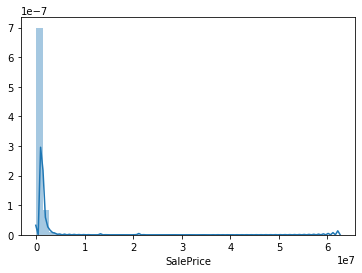

In [21]:
sns.distplot(filter_e.SalePrice)

### f. Removing mansions

In [22]:
filter_e = pd.merge(filter_e, res_bldg, how='inner', on='PIN')

In [23]:
filter_f = filter_e[filter_e.BldgGrade<12]
filter_f

,ExciseTaxNbr,Major_x,Minor_x,DocumentDate,SalePrice,RecordingNbr,Volume,Page,PlatNbr,PlatType,...,FpMultiStory,FpFreestanding,FpAdditional,YrBuilt,YrRenovated,PcntComplete,Obsolescence,PcntNetCondition,Condition,AddnlCost
0,3027422,213043,0120,2019-12-20,560000,20191226000848,,,,,...,0,0,0,1989,0,0,0,0,3,0
1,3002257,940652,0630,2019-07-22,435000,20190730001339,,,,,...,1,0,0,1994,0,0,0,0,3,2500
2,2993601,140281,0020,2019-06-04,450000,20190614000489,,,,,...,0,0,0,1986,0,0,0,0,3,0
3,3015264,124550,0098,2019-09-27,193000,20191015000395,,,,,...,1,0,0,1980,0,0,0,0,3,0
4,2980648,797320,2320,2019-03-27,540000,,,,,,...,0,0,0,1930,0,0,0,0,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28766,2972689,929085,0760,2019-01-25,1205000,20190206001611,,,,,...,0,0,0,1989,0,0,0,0,3,0
28767,2992593,405940,0095,2019-05-21,442000,20190607001670,,,,,...,0,0,0,1944,0,0,0,0,4,0
28768,3003079,381670,0025,2019-07-22,680000,20190802000628,,,,,...,1,0,1,1958,0,0,0,0,3,0
28769,3025068,615020,0505,2019-11-18,745000,20191212000602,,,,,...,0,0,0,1947,2009,0,0,0,3,0


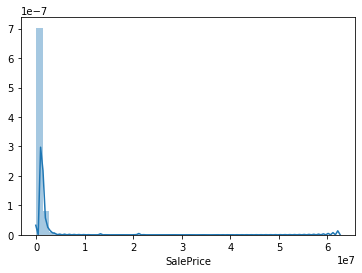

In [24]:
sns.distplot(filter_f.SalePrice)

# Normalizing the Sales Data

Based on the distribution plot we recieved after the final filter was applied, we are still not operating on a normal distribution. The following steps will be performed here simply as a means of demonstrating the process that will be used with each iteration of our model testing. 

We will first log-transform the sales data and assign those values to a new column:

<ipython-input-25-610cd9cbb35e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_f['LogSalePrice'] = np.log(filter_f.SalePrice)


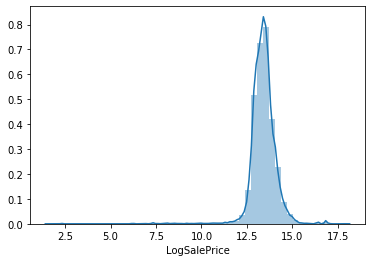

In [25]:
filter_f['LogSalePrice'] = np.log(filter_f.SalePrice)
sns.distplot(filter_f.LogSalePrice)

This is a lot more normal than our right skewed distribution from before, now let's remove the outliers.

In [26]:
z_scores = np.abs(stats.zscore(filter_f.LogSalePrice))
no_outliers = filter_f[z_scores < 3]

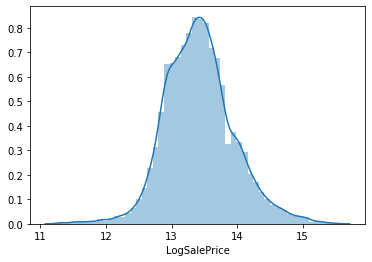

In [27]:
sns.distplot(no_outliers.LogSalePrice)

This is much closer to the type of distribution that will lend itself to linear regression.

# Final PINs creation

I will create a csv containing only the unique pins of the properties that fall under our criteria. The PIN csv will be created from the unique values of the PIN column from my filter_five dataframe. This PINS.csv file can be used to filter any additional datasets we have.

In [28]:
unique_pins = filter_f.PIN.unique()

PINS = pd.DataFrame(unique_pins, columns=['PIN']).set_index('PIN')
PINS.to_csv(data_folder+'PINS.csv')
PINS

""
PIN
2130430120
9406520630
1402810020
1245500098
7973202320
...
9290850760
4059400095
3816700025


# Export

In [44]:
res_bldg_final = pd.merge(res_bldg, PINS, on='PIN', how='inner')
res_bldg_final

# We use filter_d because it is the most recent dataframe that doesn't have the res_bldg data merged into it. 
# We want to keep only the columns from the original sales csv
sales_final = pd.merge(filter_d, PINS, on='PIN', how='inner')
sales_final

,ExciseTaxNbr,Major,Minor,DocumentDate,SalePrice,RecordingNbr,Volume,Page,PlatNbr,PlatType,...,PrincipalUse,SaleInstrument,AFForestLand,AFCurrentUseLand,AFNonProfitUse,AFHistoricProperty,SaleReason,PropertyClass,SaleWarning,PIN
0,3027422,213043,0120,2019-12-20,560000,20191226000848,,,,,...,6,3,N,N,N,N,1,8,,2130430120
1,3002257,940652,0630,2019-07-22,435000,20190730001339,,,,,...,6,3,N,N,N,N,1,8,,9406520630
2,2993601,140281,0020,2019-06-04,450000,20190614000489,,,,,...,6,3,N,N,N,N,1,8,,1402810020
3,3015264,124550,0098,2019-09-27,193000,20191015000395,,,,,...,6,15,N,N,N,N,18,8,18 51 52,1245500098
4,2980648,797320,2320,2019-03-27,540000,,,,,,...,6,3,N,N,N,N,1,8,,7973202320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28614,2972689,929085,0760,2019-01-25,1205000,20190206001611,,,,,...,6,24,N,N,N,N,18,8,12,9290850760
28615,2992593,405940,0095,2019-05-21,442000,20190607001670,,,,,...,6,3,N,N,N,N,1,8,,4059400095
28616,3003079,381670,0025,2019-07-22,680000,20190802000628,,,,,...,6,3,N,N,N,N,1,8,,3816700025
28617,3025068,615020,0505,2019-11-18,745000,20191212000602,,,,,...,6,3,N,N,N,N,1,8,,6150200505


In [45]:
res_bldg_final.to_csv(data_folder+'EXTR_ResBldg_final.csv')

sales_final.to_csv(data_folder+'EXTR_RPSale_final.csv')

# Adding more data

First, make sure you import the original csv with the right arguments, it may need special encoding, and it may need you to specifiy data type.

In [31]:
#note that some csv's need tobe read with an encoding argument set to 'latin-1'
parcel = pd.read_csv(data_folder+'EXTR_Parcel.csv', dtype={'Major': 'string', 'Minor':'string'}, encoding='latin-1')
accessory = pd.read_csv(data_folder+'EXTR_Accessory_V.csv', dtype={'Major': 'string', 'Minor':'string'}, encoding='latin-1')

Then, filter the file by our PINS

In [32]:
parcel = data_cleaning.add_PIN_column(parcel)
accessory = data_cleaning.add_PIN_column(accessory)

Check to make sure it looks okay.

In [33]:
parcel.head()

,Major,Minor,PropName,PlatName,PlatLot,PlatBlock,Range,Township,Section,QuarterSection,...,LandslideHazard,SteepSlopeHazard,Stream,Wetland,SpeciesOfConcern,SensitiveAreaTract,WaterProblems,TranspConcurrency,OtherProblems,PIN
0,807841,0410,,SUMMER RIDGE DIV NO. 02,41,,6,25,22,SW,...,N,N,N,N,N,N,N,N,N,8078410410
1,201920,0030,,DEVILLE MANOR,3,,4,21,28,SE,...,N,N,N,N,N,N,N,N,N,2019200030
2,755080,0015,,SANDER'S TO GILMAN PK & SALMON BAY,3,1,3,25,11,NW,...,N,N,N,N,N,N,N,N,N,7550800015
3,888600,0135,,VASHON GARDENS ADD,21,,3,22,8,NE,...,N,N,N,N,N,N,N,N,N,8886000135
4,643000,0185,,OSNERS 1ST ADD,37-38,1,4,25,6,NW,...,N,N,N,N,N,N,N,N,N,6430000185


In [34]:
accessory.head()

,Major,Minor,AccyType,AccyDescr,Quantity,Size,Unit,Grade,EffYr,PcntNetCondition,AccyValue,DateValued,UpdatedBy,UpdateDate,PIN
0,414010,0060,17,,8,0,0,0,0,0,0,1900-01-01 00:00:00,,1900-01-01 00:00:00,4140100060
1,423240,1120,17,,4,0,0,0,0,0,0,1900-01-01 00:00:00,,1900-01-01 00:00:00,4232401120
2,423540,0735,14,,33,0,0,0,0,0,0,1900-01-01 00:00:00,,1900-01-01 00:00:00,4235400735
3,430220,1165,17,,4,0,0,0,0,0,0,1900-01-01 00:00:00,,1900-01-01 00:00:00,4302201165
4,430220,1170,17,,4,0,0,0,0,0,0,1900-01-01 00:00:00,,1900-01-01 00:00:00,4302201170


Filter with the list of PINs

In [35]:
PINS = pd.read_csv(data_folder+'PINS.csv', dtype={'PIN': 'string'})
PINS = PINS.set_index('PIN')


parcel_final = parcel.join(PINS, how='inner', on='PIN')
print('finished parcels')

accessory_final = accessory.join(PINS, how='inner', on='PIN')
print('finished accessory')

finished parcels
finished accessory


Export it the data file, with the suffix '_final'

In [36]:
parcel_final.to_csv(data_folder+'EXTR_Parcel_final.csv')
accessory_final.to_csv(data_folder+'EXTR_Accessory_V_final.csv')